<a href="https://colab.research.google.com/github/joannarashid/flu_sim/blob/additional_data_viz/scratch_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import Counter
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

In [ ]:
class Experiment:

  def __init__(self, num_trials, pop_size, p_exposure, infection_period):
    """
    Initialize experiment parameters.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1]; 
        can be a float or a 2-tuple of floats to indicate variation.
      infection_period: Amount of time in days a person is infectious;
        can be an integer or a 2-tuple of integers to indicate variation.
    """
    self._evaluate_inputs(num_trials, pop_size, p_exposure, infection_period)

  def _evaluate_inputs(self, num_trials, pop_size, 
                       p_exposure, infection_period):
    """
    Evaluate inputs into Experiment object instantiation and set them if 
    they meet the requirements.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1].
      infection_period: Amount of time in days a person is infectious.

    Raise ValueError:
      raised when inputs do not meet certain variable types and properties.
    """
    if not isinstance(num_trials, int):
      raise ValueError("num_trials must be an integer!")
    if not isinstance(pop_size, int):
      raise ValueError("pop_size must be an integer!")
    if not isinstance(p_exposure, (float, tuple)):
      raise ValueError("p_exposure must be a float or tuple of two floats!")
    if isinstance(p_exposure, tuple):
      p_arr = np.array(p_exposure)
      p_exposure_truth_cond = (
          False not in set(p_arr >= 0) and 
          False not in set(p_arr <= 1) and 
          isinstance(p_arr[0], float) and 
          isinstance(p_arr[1], float) and
          p_arr[0] < p_arr[1]
      )
      if not p_exposure_truth_cond:
        msg = (
            "p_exposure must be a tuple of two floats (a,b)\n",
            "such that 0 <= a <= 1 and 0 <= b <= 1\n"
            "a < b"
        )
        raise ValueError(msg)
    if not isinstance(infection_period, (int, tuple)):
      raise ValueError("infection_period must be an int or tuple of two ints!")
    if isinstance(infection_period, tuple):
      a,b = infection_period
      infection_period_truth_cond = (
          isinstance(a, int) and
          isinstance(b, int) and 
          a < b
      )
      if not infection_period_truth_cond:
        msg = "infection_period must be a tuple of two ints (a,b) and a < b"
        raise ValueError(msg)
    self._num_trials = num_trials
    self._pop_size = pop_size
    self._p_exposure = p_exposure
    self._infection_period = infection_period

  def run_experiment(self):
    """
    Conduct experiment.

    Returns:
      2-Tuple containing Pandas Dataframes from experiment; trial data, 
        and daily infections raw metadata.
    """
    start = datetime.now()
    daily_infections_counts = Counter([])
    trial_data, epidemic_lengths, max_epidemic_length = \
      self.run_trials()
    for i in range(len(trial_data)):
      daily_infections_counts += Counter(trial_data[i])
      # Make all rows same length based on max_epidemic_length.
      if epidemic_lengths[i] < max_epidemic_length: 
        trial_data[i].extend([0]*(max_epidemic_length - epidemic_lengths[i]))
      trial_data[i].append(epidemic_lengths[i])

    # Build dataframe of all the trial data
    day_columns = [f'D{i}' for i in range(1, 1+max_epidemic_length)]
    columns = day_columns + ['Epidemic_Length (Days)']
    time_elapsed = datetime.now() - start
    print(f"Total time elapsed to gather data for {self._num_trials} trials: "
          f"{time_elapsed}\n\n")
    df = pd.DataFrame(trial_data, columns=columns)
    df['Total_Infections'] = 1 + df[day_columns].sum(axis=1)

    # Build dataframe of all daily infection frequencies
    daily_infection_counts_data = {
        'Number of Daily Infections': [],
        'Frequency': []
    }
    for count in sorted(daily_infections_counts.keys()):
      daily_infection_counts_data['Number of Daily Infections'].append(count)
      daily_infection_counts_data['Frequency'].append(
          daily_infections_counts[count])
    df2 = pd.DataFrame(daily_infection_counts_data)
    df2['Percentage'] = 100*df2['Frequency']/sum(df2['Frequency'])
    return df, df2

  def run_trials(self):
    """
    Conduct all the trials.

    Returns: 3-Tuple consisting of the following
      trial_data: List of trials' metadata.
      epidemic_lengths: List of trials' epidemic lengths.
      max_epidemic_length: The longest epidemic length.
    """
    epidemic_lengths = []
    trial_data = []
    max_epidemic_length = 0
    start = datetime.now()
    # Run all the trials
    for t in range(self._num_trials):
      days, num_recovery, trial_timeseries = self.flu_bern() 
      epidemic_lengths.append(days)
      trial_data.append(trial_timeseries)
      max_epidemic_length = max(max_epidemic_length, days)
    return trial_data, epidemic_lengths, max_epidemic_length

  def _set_values(self):
    """
    Initialize infected person's values for p_exposure and infection_period.

    Returns:
      dictionary: infected person's values for p_exposure and infection_period.
    """
    if isinstance(self._p_exposure, float):
      p = self._p_exposure
    else:
      p = np.random.uniform(*self._p_exposure)
    if isinstance(self._infection_period, int):
      d = self._infection_period
    else:
      d = np.random.randint(*self._infection_period)
    return {'p': p, 'd': d}

  def flu_bern(self, verbose:bool=False):
    """
    Run bernoulli trial simulation for flu spread.

    Params:
      verbose: A boolean flag whether or not to enable debug verbose logs;
                default to False.

    Returns: 3-Tuple consisting of the following
      day: The length of the epidemic as an integer.
      total_infections: The total number of individuals in recovery.
      epidemic_timeseries: The list of daily number of infections.
    """
    # Initialize set of susceptible people.
    susceptible = {i for i in range(1,self._pop_size)}

    # Randomly choose a person who initially is infected.
    first_infected = np.random.randint(1,self._pop_size)

    # Initialize infectious set and recovery set; person infectious for 3 days.

    infectious = {first_infected:self._set_values()} 
    recovery = set([])

    # Remove the first infected person from the susceptible set.
    susceptible.remove(first_infected)

    # Print this if verbose set to True
    if verbose:
      print(f"#######################Initialization#########################")
      print(f"Pr(flu exposure) = {self._p_exposure}")
      print(f"first infected person: {first_infected}")
      print(f"infectious: {infectious}")
      print(f"susceptible: {susceptible}")
      print(f"recovery: {recovery}")
      print("############################################################\n\n")

    # Initialize start of epidemic
    day = 0
    epidemic_timeseries = []

    #HL Note: we may want to add logic here to capture cases when there are 
    #multiple people infected at the beginnning of each day
    #In this case, the remaining susceptible people technically will be exposed 
    #to more interactions
    #Example: if 1 & 2 are already infected
    #3 is exposed after interacting with 1, 4 is NOT exposed after interacting 
    #with 1 but exposed after interacting with 2, etc.

    while 0 < len(infectious) <= self._pop_size:
      day += 1
      # Select the number of daily samples from Unif(0,1) 
      # equal to current number of susceptible people
      # HL note: updated logic here; each person in the susceptible set should 
      # have their own probability of getting infected each day
      sample = np.random.uniform(size=len(susceptible))

      # Each day is a series of iid Bernoulli trials
      # Each Bernoulli trial = one interaction between one infected person and 
      # one susceptible person  
      # If the sample value < p_exposure, the susceptible person becomes 
      # infected; else they remain susceptible
      
      # HL Note: update the logic here so we capture exactly who got exposed 
      # However this is slower than the original code:
      # daily_exposed = [susceptible[i] for i in range(len(susceptible)) if 
      # sample[i] < p_exposure]

      # Set daily exposed to number of remaining susceptible people if number of 
      # susceptible people is less than the daily number of infections to 
      # signify that the virus has been contracted by all members of the 
      # population.

      # Find which of the infected has the highest p_exposure
      max_p_exposure = np.max(np.array([val['p'] 
                                        for val in infectious.values()]))
      num_daily_exposed = np.sum(sample < max_p_exposure)
      
      # Add to epidemic_timeseries to track daily exposures
      epidemic_timeseries.append(num_daily_exposed)

      # Update infectious set: 
      # move people from infectious set to recovery set if they are considered 
      # no longer infectious after 3 days
      for k in infectious.keys():
        infectious[k]['d'] -= 1
        if infectious[k]['d'] == 0:
          recovery.add(k)
      infectious = {k:v for k,v in infectious.items() if v['d'] > 0}

      # Remove num_daily_exposed people from susceptible set
      # Add num_daily_exposed people to infectious sets
      for i in range(num_daily_exposed):
        k = np.random.randint(1,self._pop_size)
        while k not in susceptible: # Must select from susceptible set
          k = np.random.randint(1,self._pop_size)
        # HL Note: updated logic here so we add / remove specific people that 
        # got exposed (not here, in my own copy)
        infectious[k] = self._set_values()
        susceptible.remove(k)
      # Print this if verbose set to True
      if verbose:
        print(f"#################By end of day {day}#####################")
        print(f"sample: {sample}")
        print(f"susceptible: {susceptible}")
        print(f"Number of new exposures: {num_daily_exposed}")
        print(f"infectious: {infectious}")
        print(f"recovery: {recovery}")
        print(f"max_p_exposure: {max_p_exposure}")
        print("###########################################################\n\n")
    # Print this if verbose set to True
    if verbose:
      print(f"Epidemic length in days: {day}\n"
            f"Total infections: {len(recovery)}")
    return day, len(recovery), epidemic_timeseries


def basic_stats(df: pd.DataFrame, cols: list):
  """
  Get statistics, general and grouped.

  Params:
    df: Pandas dataframe

  Return:
    n-tuple of dataframes
  """
  output = [df.describe().T]
  for col in cols:
    output.append(df.groupby(col)[col].count())
  return tuple(output)

In [ ]:
experiment = Experiment(10,21,0.02,3)
experiment.flu_bern(verbose=True)

#flu_bern(21, 0.02, 3, verbose=True)

#######################Initialization#########################
Pr(flu exposure) = 0.02
first infected person: 15
infectious: {15: {'p': 0.02, 'd': 3}}
susceptible: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.66337843 0.4134539  0.42271053 0.52309913 0.9116158  0.34118124
 0.46836207 0.23392344 0.931481   0.57752206 0.85025541 0.91039638
 0.85841159 0.61502361 0.5800712  0.70907755 0.10399432 0.43836279
 0.24895685]
susceptible: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20}
Number of new exposures: 0
infectious: {15: {'p': 0.02, 'd': 2}}
recovery: set()
max_p_exposure: 0.02
###########################################################


#################By end of day 2#####################
sample: [0.27660914 0.97894287 0.67875558 0.84965213 0.10095346 0.80229161
 0.76464292 0.52689998 0.93711578 0.828

(7, 5, [0, 0, 3, 1, 0, 0, 0])

In [ ]:
experiment.run_trials()

([[1, 0, 0, 1, 1, 1, 0, 0, 0],
  [0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
  [0, 0, 1, 1, 1, 0, 0, 0],
  [1, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0],
  [0, 0, 0],
  [0, 0, 2, 0, 0, 0],
  [0, 0, 2, 0, 1, 0, 0, 0],
  [0, 1, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0],
  [1, 1, 0, 0, 0]],
 [9, 10, 8, 11, 3, 6, 8, 8, 4, 5],
 11)

In [ ]:
test_trial_df, test_dailyinfection_df = experiment.run_experiment()
test_trial_df

Total time elapsed to gather data for 10 trials: 0:00:00.006240




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,Epidemic_Length (Days),Total_Infections
0,0,0,0,0,0,0,0,0,0,0,0,3,1
1,0,0,1,0,2,1,0,0,0,0,0,9,5
2,1,1,1,1,0,0,0,0,0,0,0,7,5
3,1,0,0,0,0,0,0,0,0,0,0,4,2
4,0,1,0,0,0,0,0,0,0,0,0,5,2
5,0,1,1,0,0,0,0,0,0,0,0,6,3
6,0,0,1,0,1,0,0,1,0,0,0,11,4
7,0,0,3,0,0,0,0,0,0,0,0,6,4
8,1,0,0,0,0,0,0,0,0,0,0,4,2
9,0,0,0,0,0,0,0,0,0,0,0,3,1


In [ ]:
test_dailyinfection_df

,Number of Daily Infections,Frequency,Percentage
0,0,42,72.413793
1,1,14,24.137931
2,2,1,1.724138
3,3,1,1.724138


In [ ]:
experiment2 = Experiment(10,21,(0.01,0.1),(3,7))
experiment2.flu_bern(verbose=True)

#######################Initialization#########################
Pr(flu exposure) = (0.01, 0.1)
first infected person: 2
infectious: {2: {'p': 0.019105544410417365, 'd': 5}}
susceptible: {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.47556762 0.42121961 0.76807264 0.59554165 0.50785518 0.07128664
 0.0889476  0.11501689 0.5576664  0.54336788 0.54206037 0.68695222
 0.67458849 0.39309319 0.16045575 0.81043991 0.3158849  0.36069687
 0.81443654]
susceptible: {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Number of new exposures: 0
infectious: {2: {'p': 0.019105544410417365, 'd': 4}}
recovery: set()
max_p_exposure: 0.019105544410417365
###########################################################


#################By end of day 2#####################
sample: [0.11512237 0.2475161  0.38226186 0.90145755 0.37058

(31,
 19,
 [0,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  2,
  0,
  0,
  2,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0])

In [ ]:
experiment2.run_trials()

([[1, 1, 2, 0, 0, 4, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  [0, 1, 0, 1, 2, 4, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0],
  [1, 2, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
  [1, 1, 4, 4, 0, 0, 1, 0, 0, 0, 0],
  [2, 1, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 2, 1, 0, 0, 1, 0, 0, 0],
  [0, 0, 0],
  [0, 3, 2, 1, 1, 2, 1, 0, 0, 0, 0],
  [0,
   0,
   1,
   0,
   1,
   2,
   0,
   3,
   0,
   2,
   0,
   2,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0],
  [1, 0, 0, 0, 1, 2, 0, 3, 2, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 3, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]],
 [20, 16, 16, 11, 25, 3, 11, 32, 20, 24],
 32)

In [ ]:
test_trial_df2, test_dailyinfection_df2 = experiment2.run_experiment()
test_trial_df2

Total time elapsed to gather data for 10 trials: 0:00:00.016403




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D31,D32,D33,D34,D35,D36,D37,D38,Epidemic_Length (Days),Total_Infections
0,0,0,2,3,1,2,0,1,1,0,...,0,0,0,0,0,0,0,0,21,18
1,0,0,2,4,0,1,1,1,2,0,...,0,0,0,0,0,0,0,0,18,15
2,0,0,0,1,1,1,5,0,0,2,...,0,0,0,0,0,0,0,0,17,12
3,1,3,3,3,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,26,19
4,1,2,1,1,0,2,0,0,0,1,...,0,1,0,0,0,0,0,0,38,19
5,1,3,3,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,12,11
6,1,1,1,0,0,3,3,1,1,1,...,0,0,0,0,0,0,0,0,24,20
7,0,0,1,0,1,0,1,2,1,0,...,0,0,0,0,0,0,0,0,24,14
8,1,2,1,0,0,1,1,0,1,2,...,0,0,0,0,0,0,0,0,17,14
9,2,2,2,1,2,0,1,0,2,0,...,0,0,0,0,0,0,0,0,17,14


In [ ]:
test_dailyinfection_df2

,Number of Daily Infections,Frequency,Percentage
0,0,112,52.336449
1,1,71,33.177570
2,2,21,9.813084
3,3,8,3.738318
4,4,1,0.467290
5,5,1,0.467290


In [ ]:
base_experiment = Experiment(1000000, 21, 0.02, 3)
trial_df, daily_infections_freq_df = base_experiment.run_experiment()
trial_df.head()

Total time elapsed to gather data for 1000000 trials: 0:03:38.375683




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D29,D30,D31,D32,D33,D34,D35,D36,Epidemic_Length (Days),Total_Infections
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
3,0,0,1,0,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,10,6
4,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3


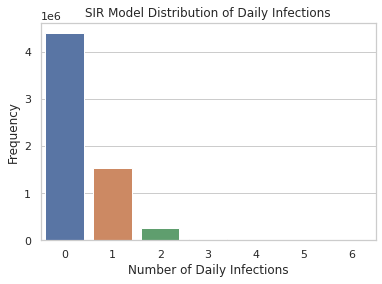

,Number of Daily Infections,Frequency,Percentage
0,0,4393714,70.856663
1,1,1524410,24.583896
2,2,253655,4.090650
3,3,26899,0.433796
4,4,2079,0.033528
5,5,90,0.001451
6,6,1,0.000016


In [ ]:
sns.barplot(data = daily_infections_freq_df,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df

In [ ]:
# Distribution of epidemic lengths in a trial
stats, groupby_epidemiclength, groupby_totalinfections = \
  basic_stats(trial_df, ['Epidemic_Length (Days)', 'Total_Infections'])

In [ ]:
groupby_epidemiclength

Epidemic_Length (Days)
3     315067
4     108496
5     109211
6     109951
7      75985
8      64358
9      52303
10     40231
11     31567
12     24539
13     18401
14     13884
15     10437
16      7595
17      5585
18      3928
19      2775
20      1875
21      1324
22       883
23       573
24       389
25       230
26       162
27        96
28        62
29        39
30        19
31        10
32        15
33         6
34         2
35         1
36         1
Name: Epidemic_Length (Days), dtype: int64

In [ ]:
# Distribution of total infections in a trial
groupby_totalinfections

Total_Infections
1     315067
2     190779
3     150099
4     112213
5      80984
6      56419
7      38113
8      24513
9      14633
10      8407
11      4724
12      2351
13       991
14       466
15       157
16        51
17        29
18         4
Name: Total_Infections, dtype: int64

In [ ]:
# Statistics per column of all the trial data
stats

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.380795,0.610751,0.0,0.0,0.0,1.0,5.0
D2,1000000.0,0.373324,0.604589,0.0,0.0,0.0,1.0,5.0
D3,1000000.0,0.365009,0.598356,0.0,0.0,0.0,1.0,5.0
D4,1000000.0,0.237736,0.509708,0.0,0.0,0.0,0.0,6.0
D5,1000000.0,0.194608,0.468329,0.0,0.0,0.0,0.0,5.0
D6,1000000.0,0.152288,0.418985,0.0,0.0,0.0,0.0,5.0
D7,1000000.0,0.111481,0.363353,0.0,0.0,0.0,0.0,5.0
D8,1000000.0,0.085219,0.319770,0.0,0.0,0.0,0.0,5.0
D9,1000000.0,0.063290,0.277356,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.045890,0.236246,0.0,0.0,0.0,0.0,5.0


In [ ]:
base_experiment2 = Experiment(1000000, 21, 0.03, 3)
trial_df2, daily_infections_freq_df2 = base_experiment2.run_experiment()
stats2, groupby_epidemiclength2, groupby_totalinfections2 = \
  basic_stats(trial_df2, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:04:54.602645




In [ ]:
trial_df2.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D31,D32,D33,D34,D35,D36,D37,D38,Epidemic_Length (Days),Total_Infections
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,2,1,1,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,10,9
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,12,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


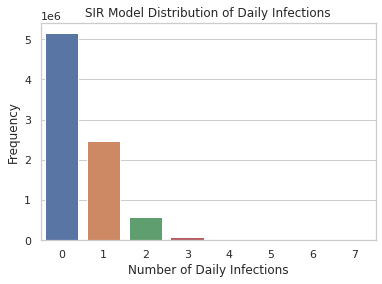

,Number of Daily Infections,Frequency,Percentage
0,0,5148554,62.105133
1,1,2466832,29.756496
2,2,577173,6.962228
3,3,87203,1.051898
4,4,9432,0.113775
5,5,816,0.009843
6,6,47,0.000567
7,7,5,0.000060


In [ ]:
sns.barplot(data = daily_infections_freq_df2,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df2

In [ ]:
groupby_epidemiclength2

Epidemic_Length (Days)
3     175611
4      86895
5      89466
6      92515
7      79333
8      72968
9      65514
10     58153
11     50555
12     43637
13     37244
14     31334
15     25763
16     21005
17     17010
18     13397
19     10615
20      8058
21      6118
22      4523
23      3339
24      2234
25      1558
26      1125
27       720
28       469
29       323
30       235
31       130
32        49
33        48
34        35
35         8
36         5
37         7
38         1
Name: Epidemic_Length (Days), dtype: int64

In [ ]:
groupby_totalinfections2

Total_Infections
1     175611
2     118900
3     116839
4     108249
5      98530
6      86925
7      74746
8      62049
9      49405
10     37763
11     27292
12     18920
13     11836
14      6888
15      3532
16      1661
17       621
18       197
19        32
20         4
Name: Total_Infections, dtype: int64

In [ ]:
stats2

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.570285,0.743508,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.553903,0.733563,0.0,0.0,0.0,1.0,7.0
D3,1000000.0,0.536243,0.721749,0.0,0.0,0.0,1.0,7.0
D4,1000000.0,0.420565,0.667416,0.0,0.0,0.0,1.0,7.0
D5,1000000.0,0.361732,0.631481,0.0,0.0,0.0,1.0,7.0
D6,1000000.0,0.303744,0.588003,0.0,0.0,0.0,0.0,6.0
D7,1000000.0,0.249788,0.541740,0.0,0.0,0.0,0.0,6.0
D8,1000000.0,0.204614,0.495834,0.0,0.0,0.0,0.0,5.0
D9,1000000.0,0.165423,0.448941,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.133140,0.406093,0.0,0.0,0.0,0.0,6.0


### An Experiment involving Varying Infection Periods

In [ ]:
base_experiment3 = Experiment(1000000, 21, 0.02, (3,7))
trial_df3, daily_infections_freq_df3 = base_experiment3.run_experiment()
stats3, groupby_epidemiclength3, groupby_totalinfections3 = \
  basic_stats(trial_df3, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:06:34.239498




In [ ]:
trial_df3

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D52,D53,D54,D55,D56,D57,D58,D59,Epidemic_Length (Days),Total_Infections
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,3
1,1,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,18,9
2,2,0,1,0,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,13,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
999996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
999997,0,0,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,5
999998,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,3


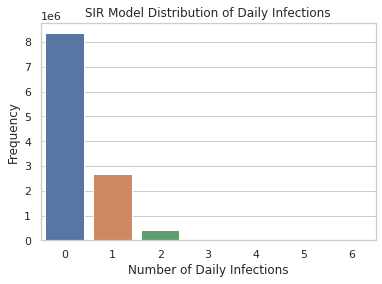

,Number of Daily Infections,Frequency,Percentage
0,0,8359283,72.722332
1,1,2673669,23.259823
2,2,417195,3.629425
3,3,41529,0.361285
4,4,2933,0.025516
5,5,178,0.001549
6,6,8,0.000070


In [ ]:
sns.barplot(data = daily_infections_freq_df3,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df3

In [ ]:
groupby_epidemiclength3

Epidemic_Length (Days)
3     78845
4     65448
5     68511
6     83929
7     62026
8     61478
9     58306
10    54687
11    51059
12    47089
13    42903
14    39719
15    36008
16    32752
17    29670
18    26251
19    23492
20    20636
21    17902
22    15854
23    13697
24    11693
25    10070
26     8702
27     7284
28     6074
29     5091
30     4200
31     3382
32     2731
33     2282
34     1835
35     1495
36     1152
37      915
38      678
39      522
40      406
41      338
42      245
43      179
44      122
45       97
46       73
47       55
48       46
49       24
50       14
51       14
52        6
53        7
54        1
55        1
56        1
57        1
58        1
59        1
Name: Epidemic_Length (Days), dtype: int64

In [ ]:
groupby_totalinfections3

Total_Infections
1     194174
2     133806
3     119158
4     108031
5      96577
6      83644
7      70225
8      57041
9      45018
10     33178
11     23467
12     15517
13      9795
14      5629
15      2837
16      1242
17       508
18       118
19        31
20         4
Name: Total_Infections, dtype: int64

In [ ]:
stats3

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.380356,0.610129,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.371982,0.604102,0.0,0.0,0.0,1.0,6.0
D3,1000000.0,0.364932,0.598477,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.328267,0.575401,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.297524,0.553884,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...
D57,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D58,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D59,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Epidemic_Length (Days),1000000.0,11.494795,7.047221,3.0,6.0,10.0,15.0,59.0


### An Experiment involving Varying Infection Probabilities

In [ ]:
base_experiment4 = Experiment(1000000, 21, (0.01,0.05), 3)
trial_df4, daily_infections_freq_df4 = base_experiment4.run_experiment()
stats4, groupby_epidemiclength4, groupby_totalinfections4 = \
  basic_stats(trial_df4, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:05:21.419815




In [ ]:
trial_df4

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D31,D32,D33,D34,D35,D36,D37,D38,Epidemic_Length (Days),Total_Infections
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,0,0,1,1,1,0,0,2,0,1,...,0,0,0,0,0,0,0,0,21,14
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
999996,0,1,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,9,5
999997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,3
999998,0,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,4


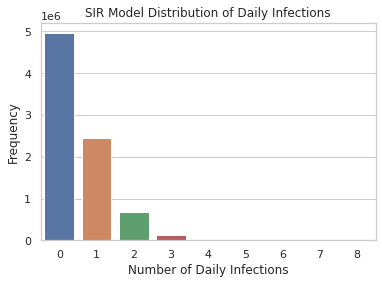

,Number of Daily Infections,Frequency,Percentage
0,0,4956364,60.311330
1,1,2448948,29.799932
2,2,665941,8.103478
3,3,126433,1.538495
4,4,18037,0.219483
5,5,2059,0.025055
6,6,169,0.002056
7,7,13,0.000158
8,8,1,0.000012


In [ ]:
sns.barplot(data = daily_infections_freq_df4,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df4

In [ ]:
groupby_epidemiclength4

Epidemic_Length (Days)
3     218785
4      66045
5      76765
6      89162
7      70830
8      69982
9      65090
10     57590
11     51724
12     45304
13     38491
14     33090
15     27127
16     21858
17     17512
18     13684
19     10434
20      7882
21      5778
22      4219
23      2913
24      2019
25      1380
26       887
27       563
28       359
29       221
30       108
31        82
32        50
33        30
34        19
35         5
36         8
37         1
38         3
Name: Epidemic_Length (Days), dtype: int64

In [ ]:
groupby_totalinfections4

Total_Infections
1     218785
2     107520
3      89936
4      83326
5      79133
6      74696
7      69735
8      63191
9      54898
10     46108
11     37202
12     28171
13     19856
14     13122
15      7785
16      3970
17      1735
18       637
19       174
20        20
Name: Total_Infections, dtype: int64

In [ ]:
stats4

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.569784,0.772902,0.0,0.0,0.0,1.0,7.0
D2,1000000.0,0.590551,0.781737,0.0,0.0,0.0,1.0,8.0
D3,1000000.0,0.604393,0.787086,0.0,0.0,0.0,1.0,7.0
D4,1000000.0,0.459486,0.724285,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.405679,0.688954,0.0,0.0,0.0,1.0,7.0
D6,1000000.0,0.342052,0.641298,0.0,0.0,0.0,1.0,7.0
D7,1000000.0,0.277270,0.584840,0.0,0.0,0.0,0.0,6.0
D8,1000000.0,0.228274,0.536531,0.0,0.0,0.0,0.0,6.0
D9,1000000.0,0.183362,0.483775,0.0,0.0,0.0,0.0,6.0
D10,1000000.0,0.145168,0.432472,0.0,0.0,0.0,0.0,6.0


### An Experiment invovling both Varying Infection Probabilities and Periods

In [ ]:
base_experiment5 = Experiment(1000000, 21, (0.01,0.05), (3,7))
trial_df5, daily_infections_freq_df5 = base_experiment5.run_experiment()
stats5, groupby_epidemiclength5, groupby_totalinfections5 = \
  basic_stats(trial_df5, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:10:31.321479




In [ ]:
trial_df5

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D54,D55,D56,D57,D58,D59,D60,D61,Epidemic_Length (Days),Total_Infections
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
1,0,2,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,11,6
2,2,0,2,1,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,23,12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
4,0,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,20,13
999996,1,1,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,6
999997,1,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,28,11
999998,0,2,0,1,3,1,1,1,0,0,...,0,0,0,0,0,0,0,0,16,11


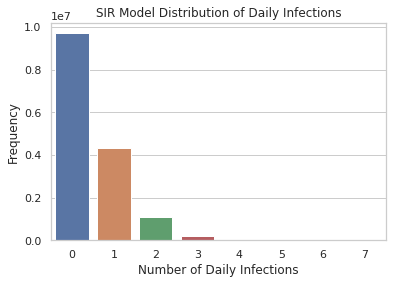

,Number of Daily Infections,Frequency,Percentage
0,0,9699972,63.385149
1,1,4302163,28.112787
2,2,1079981,7.057212
3,3,191764,1.253095
4,4,26250,0.171532
5,5,2797,0.018277
6,6,268,0.001751
7,7,30,0.000196


In [ ]:
sns.barplot(data = daily_infections_freq_df5,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df5

In [ ]:
groupby_epidemiclength5

Epidemic_Length (Days)
3     54152
4     42219
5     40296
6     44806
7     32345
8     34710
9     37043
10    38508
11    40662
12    41411
13    42646
14    43003
15    43203
16    42344
17    41611
18    40693
19    38342
20    36244
21    34076
22    31410
23    28716
24    25546
25    23194
26    20206
27    17935
28    15546
29    13129
30    11174
31     9292
32     7822
33     6175
34     5004
35     3943
36     3040
37     2417
38     1877
39     1399
40     1078
41      820
42      569
43      426
44      299
45      214
46      153
47       85
48       70
49       43
50       35
51       19
52       17
53       14
54        4
55        6
56        2
57        2
58        1
59        1
60        2
61        1
Name: Epidemic_Length (Days), dtype: int64

In [ ]:
groupby_totalinfections5

Total_Infections
1     131236
2      58853
3      46866
4      46582
5      48832
6      53245
7      58514
8      63021
9      66379
10     69451
11     69547
12     67595
13     61419
14     52884
15     42541
16     30360
17     18967
18      9443
19      3533
20       732
Name: Total_Infections, dtype: int64

In [ ]:
stats5

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.570222,0.774206,0.0,0.0,0.0,1.0,7.0
D2,1000000.0,0.591147,0.782586,0.0,0.0,0.0,1.0,7.0
D3,1000000.0,0.605269,0.785656,0.0,0.0,0.0,1.0,7.0
D4,1000000.0,0.574634,0.774228,0.0,0.0,0.0,1.0,7.0
D5,1000000.0,0.540954,0.757425,0.0,0.0,0.0,1.0,7.0
...,...,...,...,...,...,...,...,...
D59,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D60,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D61,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Epidemic_Length (Days),1000000.0,15.303225,8.298425,3.0,9.0,15.0,21.0,61.0


## Data Viz

In [ ]:
#!pip install -U matplotlib

In [ ]:
def long(df, pop_size):
  """
  This function takes the output df from run_experiment()
  and cleans and transforms data for epidimiological graphing.
  The df is melted to a long form on the variables, simulation and day.
  Additional variable created include cummulative totals for infections, 
  recovered agents, and susceptible agents.

  Params:
    df: Pandas dataframe,
    pop_size: Size of population as an integer.

  Returns: 
    Pandas dataframe melted and transformed.
  """
  #cleaning orginal df
  long_df = df.copy()
  long_df.drop(columns=long_df.columns[-2:], axis=1,  inplace=True)
  long_df.reset_index(inplace=True)

  #creating simulation column
  long_df = long_df.rename(columns = {'index':'simulation'}) 

  #melting on simulation and day
  long_df = long_df.melt(id_vars=['simulation'], 
                         var_name = "day", 
                         value_name = "daily infections")
  #removing "D" from day values
  long_df['day'] = long_df["day"].map(lambda x: x.lstrip('D')).astype(int)

  #creating cumulative sum of infections for each day
  long_df['daily infections'] = long_df['daily infections'].astype(int)
  long_df = long_df.sort_values(["simulation", "day"])
  long_df['total infections'] = long_df.groupby(['simulation'])\
    ['daily infections'].cumsum().astype(int)
   
  #creating cumulative sum of recovered agents for each day
  long_df['recovered'] = long_df['total infections'].shift(
      3, axis = 0, fill_value = 0).astype(int)
  long_df.loc[long_df.day == 1, 'recovered'] = 0
  long_df.loc[long_df.day == 2, 'recovered'] = 0
  long_df.loc[long_df.day == 3, 'recovered'] = 0

  #creating susceptible value for each day
  long_df['susceptible'] = pop_size - long_df['total infections']
  long_df = long_df.sort_values(["simulation", "day"])


# creating value for prevalence
  long_df['prevalence'] = long_df['daily infections']/pop_size

  return long_df

In [ ]:
base_experiment_10k = Experiment(10000, 21, 0.02, 3)
df_10k, daily_infections_freq_df_10k = base_experiment_10k.run_experiment()
long_df_10k = long(df_10k, 21)
long_df_10k

Total time elapsed to gather data for 10000 trials: 0:00:02.918204




,simulation,day,daily infections,total infections,recovered,susceptible,prevalence
0,0,1,0,0,0,21,0.0
10000,0,2,0,0,0,21,0.0
20000,0,3,0,0,0,21,0.0
30000,0,4,0,0,0,21,0.0
40000,0,5,0,0,0,21,0.0
...,...,...,...,...,...,...,...
229999,9999,23,0,4,4,17,0.0
239999,9999,24,0,4,4,17,0.0
249999,9999,25,0,4,4,17,0.0
259999,9999,26,0,4,4,17,0.0


In [ ]:
# table for report descriptive statistics
stats_df = long_df_10k.describe()
stats_df.drop(stats_df.columns[[0, 1]], axis=1, inplace=True) #dropping day and simulation columns
stats_df = stats_df.join(trial_df['Epidemic_Length (Days)'].describe()) #needs review
stats_df
#stats_df.to_csv('stats_df.csv')

,daily infections,total infections,recovered,susceptible,prevalence,Epidemic_Length (Days)
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,1000000.000000
mean,0.077393,1.837333,1.605156,19.162667,0.003685,6.200848
std,0.310262,2.043024,1.978674,2.043024,0.014774,3.608782
min,0.000000,0.000000,0.000000,7.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,18.000000,0.000000,3.000000
50%,0.000000,1.000000,1.000000,20.000000,0.000000,5.000000
75%,0.000000,3.000000,3.000000,21.000000,0.000000,8.000000
max,5.000000,14.000000,14.000000,21.000000,0.238095,36.000000


In [ ]:
# table of mean (or expected) values for each day
mean_df = long_df_10k.groupby(['day'])['daily infections', 'total infections', 'recovered', 'susceptible', 'prevalence'].mean()
mean_df.head()
#mean_df.to_csv('mean_df.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,daily infections,total infections,recovered,susceptible,prevalence
day,,,,,
1,0.3631,0.3631,0.0000,20.6369,0.017290
2,0.3769,0.7400,0.0000,20.2600,0.017948
3,0.3549,1.0949,0.0000,19.9051,0.016900
4,0.2294,1.3243,0.3631,19.6757,0.010924
5,0.2020,1.5263,0.7400,19.4737,0.009619


Text(0.5, 1.0, 'SIR Model Distribution of Epidemic Length')

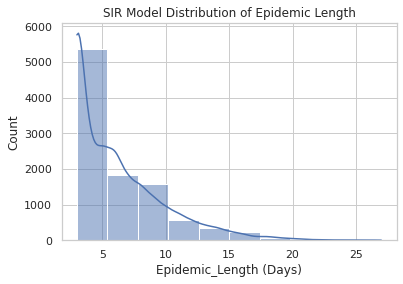

In [ ]:
sns.histplot(data = df_10k, x = "Epidemic_Length (Days)", kde =True, bins = 10)
plt.title('SIR Model Distribution of Epidemic Length')
#plt.savefig('sir_dist_epi_len.png')

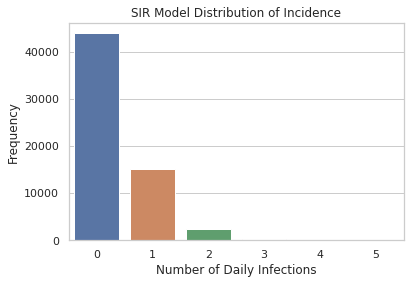

,Number of Daily Infections,Frequency,Percentage
0,0,43880,71.065332
1,1,15135,24.511709
2,2,2456,3.977586
3,3,254,0.411363
4,4,18,0.029152
5,5,3,0.004859


In [ ]:
sns.barplot(data = daily_infections_freq_df_10k,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Incidence')
plt.show()
daily_infections_freq_df_10k
#plt.savefig('dist_total_inf.png')

Text(0.5, 1.0, 'SIR Model Distribution of Infection Totals')

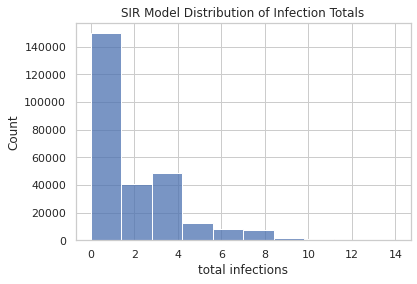

In [ ]:
sns.histplot(data = long_df_10k, x = "total infections", bins = 10)
plt.title('SIR Model Distribution of Infection Totals')
#plt.savefig('dist_total_inf.png')

Text(0.5, 1.0, 'SIR Model Mean Incidence')

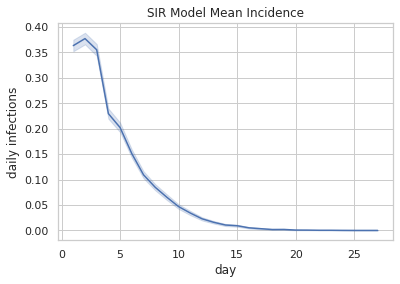

In [ ]:
sns.lineplot(x = "day", y = "daily infections", data = long_df_10k)
plt.title('SIR Model Mean Incidence')
#plt.savefig('sir_incidence.png')

Text(0.5, 1.0, 'SIR Model Mean Prevalence')

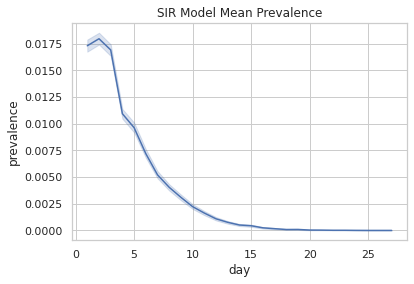

In [ ]:
sns.lineplot(x = "day", y = "prevalence", data = long_df_10k)
plt.title('SIR Model Mean Prevalence')
#plt.savefig('sir_prevalence.png')

Text(0.5, 1.0, 'SIR Model Mean Total Infections')

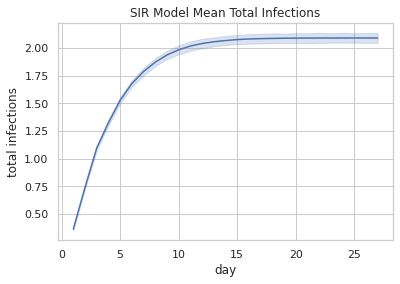

In [ ]:
sns.lineplot(x = "day", y = "total infections", data = long_df_10k)
plt.title('SIR Model Mean Total Infections')
#plt.savefig('sir_total_inf.png')

Text(0.5, 1.0, 'Distibution of Total Infections by Day')

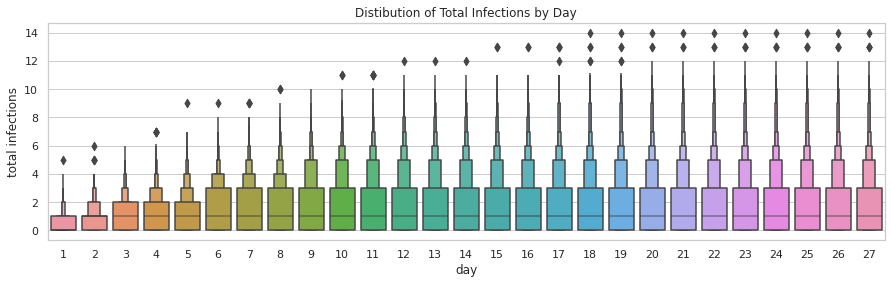

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
sns.boxenplot(data = long_df_10k , x = "day", y = "total infections")
plt.title('Distibution of Total Infections by Day')
#plt.savefig('dist_total_daily_inf.png')

In [ ]:
sir_df_10k = long_df_10k.melt(
    id_vars=['simulation', 'day'],
    value_vars = ["total infections", "recovered", "susceptible"]
)
sir_df_10k

,simulation,day,variable,value
0,0,1,total infections,0
1,0,2,total infections,0
2,0,3,total infections,0
3,0,4,total infections,0
4,0,5,total infections,0
...,...,...,...,...
809995,9999,23,susceptible,17
809996,9999,24,susceptible,17
809997,9999,25,susceptible,17
809998,9999,26,susceptible,17


Text(0.5, 1.0, 'SIR Model')

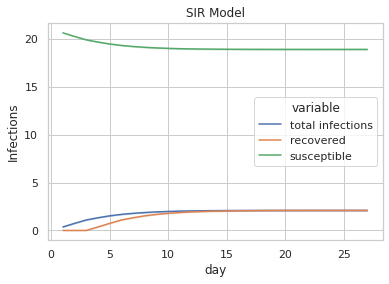

In [ ]:
sns.lineplot(x = "day", y = "value", data = sir_df_10k, hue = "variable")
plt.ylabel('Infections')
plt.title('SIR Model')
#plt.savefig('sir_ts.png')

### Plotting each simulation

In [ ]:
experiment_100 = Experiment(100, 200, 0.02, 3)
df_100, daily_infections_freq_df_100 = experiment_100.run_experiment()
long_df_100 = long(df_100, 200)

Total time elapsed to gather data for 100 trials: 0:00:00.328440




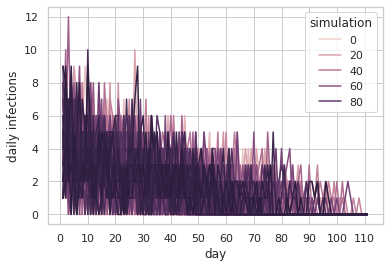

In [ ]:
plt = sns.lineplot(data = long_df_100, x = "day", y = "daily infections", hue = "simulation")
plt.xaxis.set_major_locator(ticker.MultipleLocator(10))

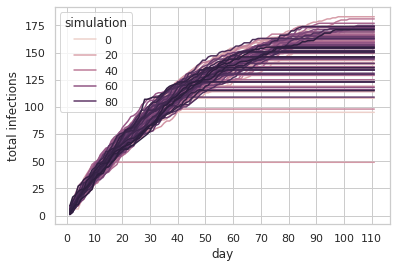

In [ ]:
plt = sns.lineplot(data = long_df_100 , x = "day", y = "total infections", hue = "simulation")
plt.xaxis.set_major_locator(ticker.MultipleLocator(10))

## Additional Analysis
This section includes:

* Effect of varied infection probability
* Effect of varied infection length
* Effect of varied class size


In [ ]:
import matplotlib.pyplot as plt
def coupled_experiments(params, epi_len, dfs, index, val):
  """
  Run a set of experiments and update epidemic lengths and dfs passed by ref.

  Params:
    params: tuple of parameters for Experiment.
    epi_len: Pandas dataframe of epidemic lengths.
    dfs: Dictionary of Pandas dataframes.
    index: integer index as key for entry into dfs.
    val: value of a variable which to assess its effects on.
  """
  expdf, daily_infection_freq_expdf = Experiment(*params).run_experiment()
  epi_len[str(val)] = expdf[["Epidemic_Length (Days)"]]
  dfs[index] = long(expdf, params[1])


def data_varying_infection_probs(infection_probs, num_trials, 
                                 pop_size, infection_period):
  """
  Visualize the effect of varying infection probabilities in epidemic.

  Params:
    infection_probs: list of infection probabilities.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  prob_dfs = {}
  epi_len = pd.DataFrame()
  for i,p in enumerate(infection_probs):
    coupled_experiments(
        (num_trials, pop_size, p, infection_period),
        epi_len,
        prob_dfs,
        i,
        p
    )
  epi_len.reset_index(inplace=True)
  epi_len = epi_len.rename(columns = {'index':'simulation'})
  epi_len = epi_len.melt(id_vars=['simulation'], 
                         var_name = "infection probability", 
                         value_name = "length of epidemic")
  return epi_len, prob_dfs


def data_varying_effect_infection_lengths(infection_lengths, num_trials, 
                                          pop_size, p_exposure):
  """
  Visualize the effect of varying infection length in epidemic.

  Params:
    infection_lengths: list of infection period lengths.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  #infection_lengths = [1,2,3,4,5]
  l_dfs = {}
  epi_len2 = pd.DataFrame()
  for i,l in enumerate(infection_lengths):
    coupled_experiments(
        (num_trials, pop_size, p_exposure, l),
        epi_len2,
        l_dfs,
        i,
        l
    )
  epi_len2.reset_index(inplace=True)
  epi_len2 = epi_len2.rename(columns = {'index':'simulation'})
  epi_len2 = epi_len2.melt(id_vars=['simulation'], 
                           var_name = "infection length", 
                           value_name = "length of epidemic")
  return epi_len2, l_dfs


def data_varying_effect_class_size(class_size, num_trials, p_exposure, 
                                   infection_period):
  """
  Visualize the effect of varying class size.

  Params:
    class_size: list of class size.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  #class_size = [*range(10, 101, 10)]
  c_dfs = {}
  epi_len3 = pd.DataFrame()
  for i,c in enumerate(class_size):
    coupled_experiments(
        (num_trials, c, p_exposure, infection_period),
        epi_len3,
        c_dfs,
        i,
        c
    )
  epi_len3.reset_index(inplace=True)
  epi_len3 = epi_len3.rename(columns = {'index':'simulation'})
  epi_len3 = epi_len3.melt(id_vars=['simulation'], 
                           var_name = "class size", 
                           value_name = "length of epidemic")
  return epi_len3, c_dfs


def run_variation_analysis(num_trials, pop_size, p_exposure, infection_period):
  """
  Run experiments with one of the key parameters as a list.

  Params:
    num_trials: Must be an integer.
    pop_size: Can be either an integer or a list of integers.
    p_exposure: can be either a float or a list of floats.
    infection_period: can be either an integer or a list of integers.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  if not isinstance(num_trials, int):
    raise ValueError("num_trials must be an integer!")
  if (isinstance(pop_size, list), 
      isinstance(p_exposure, float), 
      isinstance(infection_period, int)) == (True, True, True):
      return data_varying_effect_class_size(
          pop_size, 
          num_trials, 
          p_exposure, 
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, list), 
      isinstance(infection_period, int)) == (True, True, True):
      return data_varying_infection_probs(
          p_exposure, 
          num_trials, 
          pop_size,
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, float), 
      isinstance(infection_period, list)) == (True, True, True):
      return data_varying_effect_infection_lengths(
          infection_period, 
          num_trials,
          pop_size, 
          p_exposure
      )
  raise RuntimeError(
      "Check your inputs into this function and try again!"
      "Hint: num_trials must always be a int; as for the rest of the variables,"
      " only one of them can be a list!"
  )


def graph_against_epidemic_lengths(epi_len, x, hue_quantity, bins):
  """
  Graph against epidemic lengths.

  Params:
    epi_len: Pandas dataframe of epidemic lengths.
    x: x-axis label.
    hue_quantity: hue property which is also the quantity of interest.
    bins: Number of bins.
  """
  fig, ax =plt.subplots(1,2)
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, bins = bins, ax=ax[0])
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, 
               bins = bins, element = "poly", ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Distibution of Epidemic Lengths by {hue_quantity}')


def graph_against_infection_counts(vals, dfs, x, y1, y2, 
                                   label, quantity, legend=None):
  """
  Graph against infection counts.

  Params:
    vals: list of values.
    dfs: Dictionary of Pandas dataframes.
    x: x-axis label.
    y1: y-axis label for first graph.
    y2: y-axis label for second graph.
    label: legend label.
    quantity: actual variable of interest.
    legend: Legend parameter; default to None as parameter is optional.
  """
  fig, ax = plt.subplots(1,2)
  for i,v in enumerate(vals):
    sns.lineplot(x = x, y = y1, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[0])
    sns.lineplot(x = x, y = y2, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Incidence and Total Infections by {quantity}')
  if legend:
    fig.legend(title = legend)

### Varied Infection probability
$N = 21$, $\text{infection period (days)} = 3$

In [ ]:
p_exposures = [.01, .05, .1, .25, .5, .75]
epi_len1, prob_dfs = run_variation_analysis(10000, 21, p_exposures, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.463977


Total time elapsed to gather data for 10000 trials: 0:00:04.246845


Total time elapsed to gather data for 10000 trials: 0:00:06.419749


Total time elapsed to gather data for 10000 trials: 0:00:07.703218


Total time elapsed to gather data for 10000 trials: 0:00:06.753605


Total time elapsed to gather data for 10000 trials: 0:00:05.293191




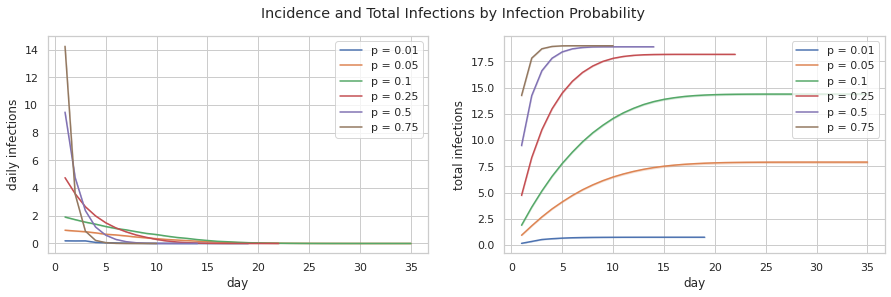

In [ ]:
graph_against_infection_counts(p_exposures, 
                               prob_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'p',
                               'Infection Probability')
#plt.savefig('inf_prob.png')

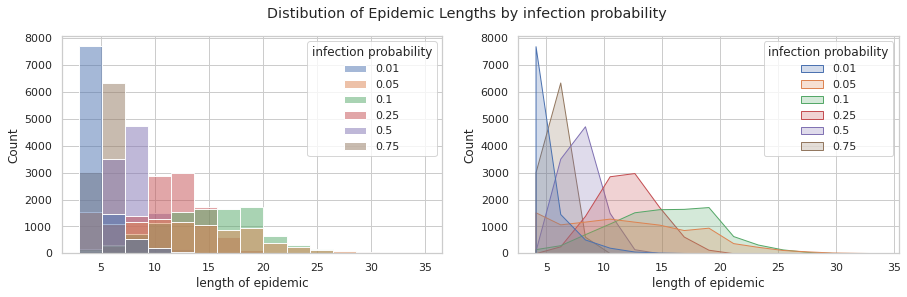

In [ ]:
graph_against_epidemic_lengths(epi_len1,
                               "length of epidemic",
                               "infection probability",
                               15)
#plt.savefig('inf_prob_epi_len.png')

### Varied Infection Length

$N=21$, $p=0.02$

In [ ]:
infection_periods = [1,2,3,4,5]
epi_len2, l_dfs = run_variation_analysis(10000, 21, 0.02, infection_periods)

Total time elapsed to gather data for 10000 trials: 0:00:00.533604


Total time elapsed to gather data for 10000 trials: 0:00:01.174985


Total time elapsed to gather data for 10000 trials: 0:00:02.032193


Total time elapsed to gather data for 10000 trials: 0:00:03.006411


Total time elapsed to gather data for 10000 trials: 0:00:04.545676




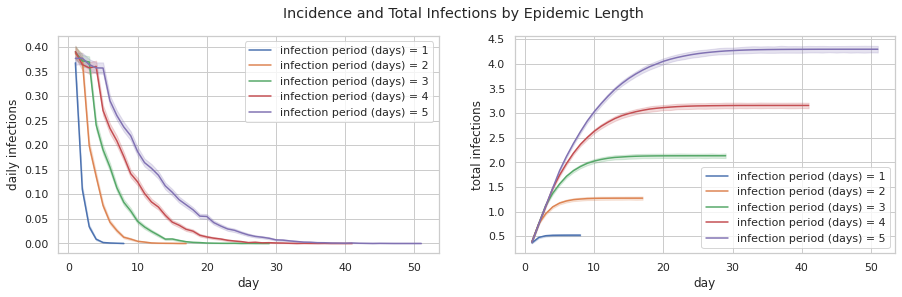

In [ ]:
graph_against_infection_counts(infection_periods, 
                               l_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'infection period (days)',
                               'Epidemic Length')
#plt.savefig('inf_len.png')

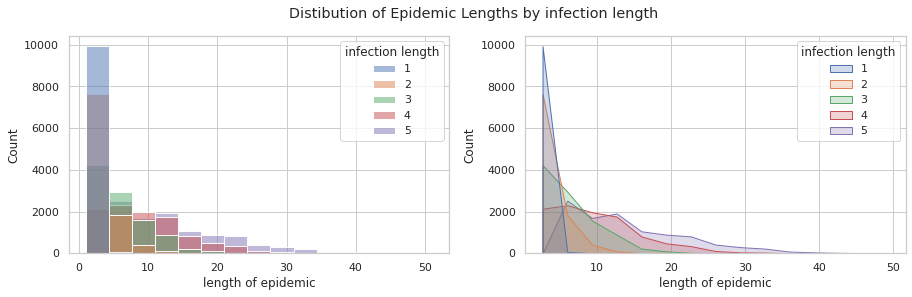

In [ ]:
graph_against_epidemic_lengths(epi_len2,
                               "length of epidemic",
                               "infection length",
                               15)
#plt.savefig('inf_len_epi_len.png')

### Varied Class Size

$p=0.02$, $\text{infection period (days)} = 3$

In [ ]:
pop_sizes = [*range(10, 101, 10)]
epi_len3, c_dfs = run_variation_analysis(10000, pop_sizes, 0.02, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.258105


Total time elapsed to gather data for 10000 trials: 0:00:02.003158


Total time elapsed to gather data for 10000 trials: 0:00:02.791055


Total time elapsed to gather data for 10000 trials: 0:00:04.235754


Total time elapsed to gather data for 10000 trials: 0:00:05.525616


Total time elapsed to gather data for 10000 trials: 0:00:08.366223


Total time elapsed to gather data for 10000 trials: 0:00:09.288764


Total time elapsed to gather data for 10000 trials: 0:00:10.532783


Total time elapsed to gather data for 10000 trials: 0:00:12.444596


Total time elapsed to gather data for 10000 trials: 0:00:14.403810




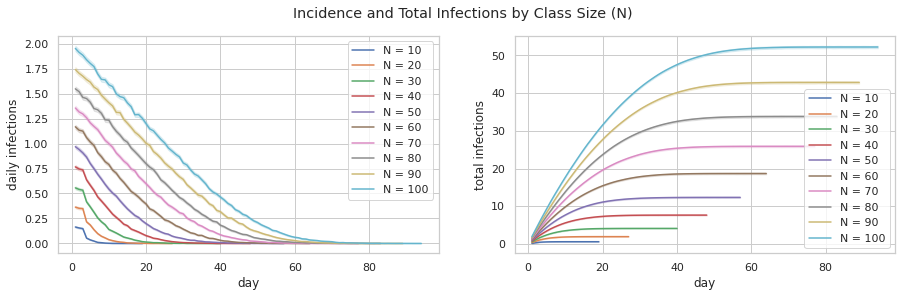

In [ ]:
graph_against_infection_counts(pop_sizes, 
                               c_dfs,
                               "day",
                               "daily infections",
                               "total infections",
                               'N',
                               "Class Size (N)")
#plt.savefig('class_size.png')

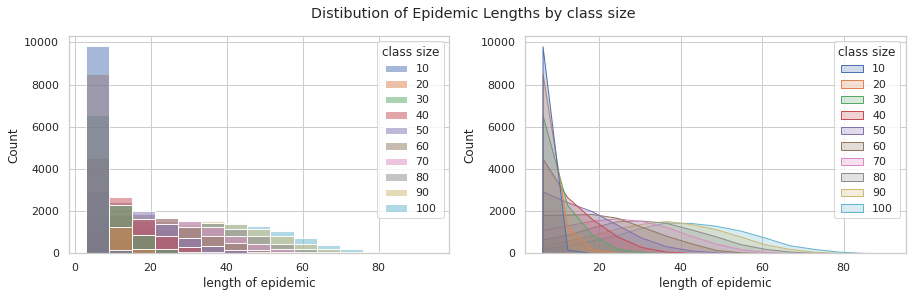

In [ ]:
graph_against_epidemic_lengths(epi_len3,
                               "length of epidemic",
                               "class size",
                               15)
#plt.savefig('class_size_epi_len.png')